In [5]:
library(dplyr)
library("ggpubr")
samples<-read.csv("./labeled.csv")

# Experiment Description

## overview

In [4]:
Running database(pgbench) workload on a AWS dedicated host.
That host can provision 16*c3.large VMs.
Those VMs share disks physically attached to the host (instance store).
Each time only part of VMs work actively.
                  |VM1 |
                   ...
       |VM15| ... |VM15|
|VM16| |VM16| ... |VM16|
--------------------------> Time line
  set1  set2  ... set16.    Experiment name

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: Running database
            ^


## details

- Each _|VMx|_ block described on above time line consist of **3** runs.
- Thus, in the _.csv_ file **3** entries are labeled **set:=1**.
- Further more, **48** (=3\*16) entries are labeled by **vmID:=16**

Each entry of the _.csv_ file is generated by following command
> $pgbench --client=10 --jobs=10 --time=60  ubuntu

 '10 connections are created by 10 clients targeting to postgreSQL server'<br>
 'pgbench is going to use 1- threads to handle all connections if possible'<br>
 'pgbench will proceed performance test until the limit of 60 seconds'
 

 *Add a init script for instance store - July 22. 2018*
> 
\#!bin/bash<br>
\#Stop the Postgres server:<br>
sudo service postgresql stop<br>
sleep 30<br>
>
\#Move the database files to the new data disk:<br>
sudo mv /var/lib/postgresql/9.5/main /mnt/postgres-data9.5<br>
sleep 10<br>
>
\#Edit postgresql.conf:<br>
CFG=/etc/postgresql/9.5/main/postgresql.conf<br>
K=data_directory<br>
V=\'/mnt/postgres-data9.5\'<br>
sudo sed -i "/^$K/c$K = $V" $CFG<br>
>
\#Start Postgres:<br>
sudo service postgresql start<br>

# Analysis

## indicators of whole experiment

In [6]:
wholeExp = samples[,'transactions']
indicators=data.frame()
indicators<-rbind(indicators,c(range(wholeExp),mean(wholeExp),median(wholeExp)))
names(indicators)<-c('min','max','mean','median')
indicators

min,max,mean,median
66946,85192,76723.88,76133


### (max-min)/min

In [7]:
(indicators$max - indicators$min)/indicators$min

[1] 0.272548

### mean && 95percentile

In [8]:
percentile=data.frame(quantile(samples$transactions,c(0.5,0.95)))
names(percentile) <- c('mean && 95percentile')
percentile

,mean && 95percentile
50%,76133.00
95%,83326.65


## statistics of each test set 

In [36]:
statistic_result=data.frame()
for(i in 1:16){
    thisSet=samples[samples$set==i,'transactions']
    statistic_result=rbind(statistic_result,c(range(thisSet),mean(thisSet),median(thisSet),var(thisSet),i))
}
names(statistic_result)<-c('min','max','mean','median','var','set')
statistic_result

min,max,mean,median,var,set
83924,84322,84137.67,84167.0,40246.33,1
83975,85192,84667.67,84667.0,197946.67,2
81150,84705,83291.11,84050.0,1927116.36,3
80778,84340,82795.08,83267.0,1425865.17,4
80865,83533,81878.60,81874.0,680833.26,5
81263,83290,82302.39,82289.0,379990.72,6
79456,82706,81425.43,81585.0,774029.36,7
78850,82694,80680.58,80369.5,1542082.08,8
78572,82143,80342.15,80301.0,1153196.44,9
76181,82399,78760.03,78003.5,3892554.59,10


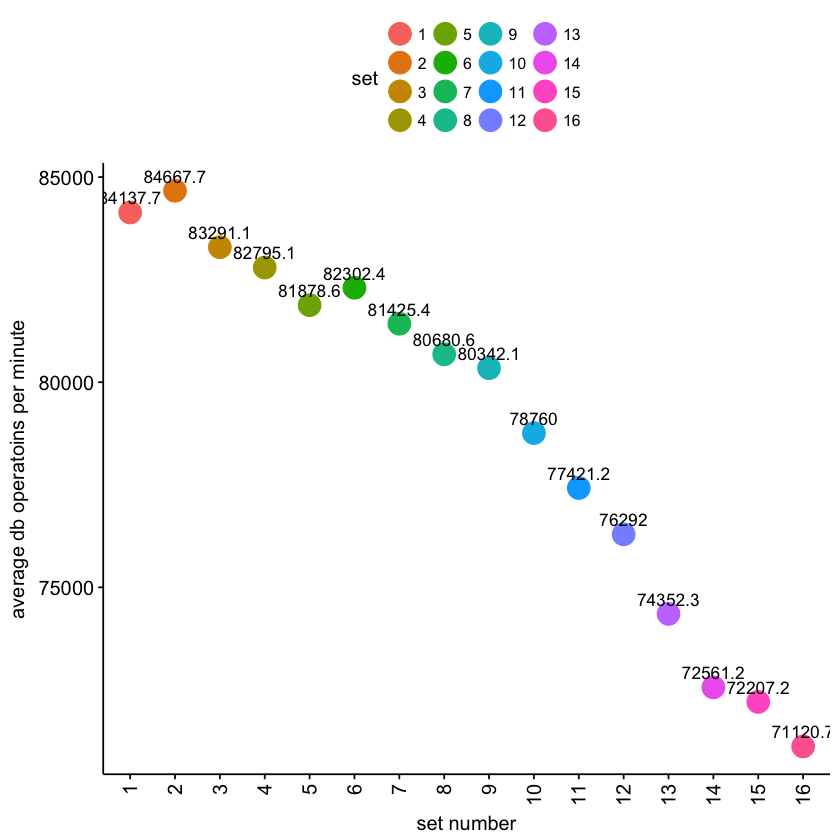

In [35]:
ggdotchart(statistic_result, x = "set", y = "mean",
           xlab = "set number",
           ylab = "average db operatoins per minute",
           color = "set",                                # Color by groups
           sorting = "ascending",                        # Sort value in descending order
            dot.size = 6, 
           label = round(statistic_result$mean,1), 
           ggtheme = theme_pubr()                        # ggplot2 theme
           )

### Graph2 distribution of each (set,vmID) pair

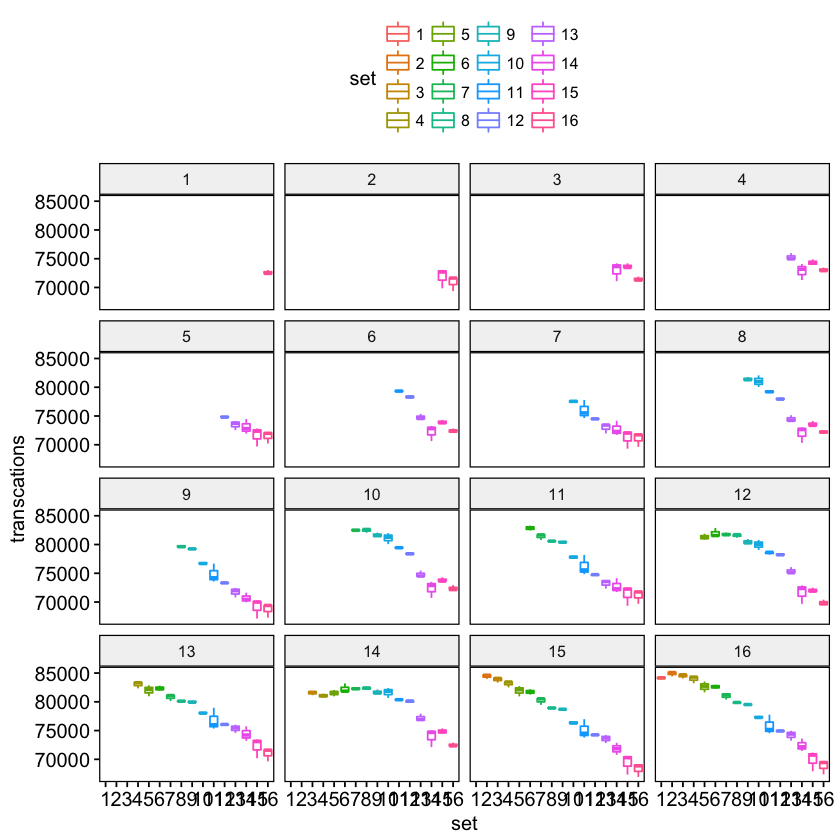

In [22]:
ggboxplot(samples, x = "set", y = "transactions", 
          color = "set", 
          ylab = "transcations", xlab = "set",facet.by='vmID')

# Conclusion

Graph2 shows a result perfectly matched our expectation.<br>
Perormance of VM16 degraded from 85000 per transactions  minute to about 70000 after other VMs are involved.<br>
In addtion, local disks performed a 85000 is resonbale given that EBS-backed volume performed around 60000 while other configurations are the same.<br> 

Let's take a look at the VM16.
It is roughly linear except first 1 or 2 sets of test for each VM.<br>
Training effect or cache may be the reason that set1 isn't better than set2,<br>
where we respectively got 84137.67 and 84667.67 transactions on average of 3 cycle.<br>

In [ ]:
#TODO 16->1